<a href="https://colab.research.google.com/github/litvinenkonikita/Physics_based_ML/blob/main/Pipe_analytical_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

It is supposed that the Newtonian fluid flows through a cylindrical pipe with radius $R$. The flow is steady, the Reynolds number is smaller than the critical one $Re < Re^* {\approx} 1100...1400$ and the pipe length is greater than the critical one $L_3 > 0.16RRe$. 

# Initialization

## Import libraries

In [25]:
# Pytorch module
import torch

# Visualization tools
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np

## Settings

In [26]:
#Geometric parameters
n = 100
L_3 = 0.52 
R = 0.008/4

#Static parameters

#Dynamic parameters
Q_3 = 1E-5 #flow rate
mu = 4E-3 #viscosity
density = 1E+3 #density

#Cartesian coordinates
x_1 = torch.linspace(-2*R, 2*R, n)
x_1, x_2 = torch.meshgrid(x_1, x_1)

# Analytical solution

The task of fluid flow through a pipe is known as Poiseuille flow and it has a simple analytical solution given in **cylindrical coordinates** $[\rho, \theta, x_3]$:

\begin{equation}
    {v_3} = - \frac{1}{4\mu}\frac{\partial p}{\partial x_3}(R^2 - \rho^2),
\end{equation}
where ${\partial p}/{\partial x_3}$ is the pressure drop along the axis of the cylinder.

The velocity function $v_3$ has in **Cartesian coordinates** $[x_1, x_2, x_3]$ the following form:

In [27]:
dpdx_3 = - Q_3*8*mu/(np.pi*(R**4))
v_3 = -1/(4*mu)*dpdx_3*(R**2 - x_1**2 - x_2**2)
#crop negative values (put mask of the pipe)
dpdx_3, v_3.max()

(-6366.197723675812, tensor(1.5903))

*Visualization.*

Crop the values outside the pipe (put on mask of the pipe).

In [28]:
v_3[x_1**2 + x_2**2 > R**2]=0

Represent the velocity function $v_3$ as a surface.

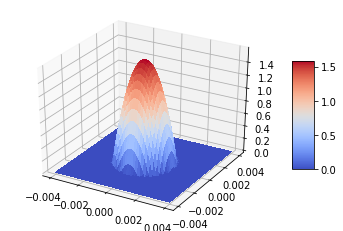

In [29]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(np.array(x_1),np.array(x_2), np.array(v_3), cmap=cm.coolwarm, linewidth=0, antialiased=False)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

The flow rate trough the pipe cross section (surface $S_3$) is equal to:

\begin{equation}
    {Q_3} = \iint_{S_3} v_3 \rho\,d\rho\,d\theta =  - \frac{\pi}{8}\frac{\partial p}{\partial x_3}\frac{R^4}{\mu}.
\end{equation}

External power:
\begin{equation}
    {Ext} = \frac{\partial p}{\partial x_3}L\iint_{S_3} v_3 \rho\,d\rho\,d\theta =  - \frac{\pi}{8}(\frac{\partial p}{\partial x_3})^2L_3\frac{R^4}{\mu}.
\end{equation}

In [30]:
Ext = -torch.pi/(8*mu)*(dpdx_3**2)*L_3*(R**4)
Ext

-0.03310422816311422

Check Reynolds number $Re$ and the critical length $L_{cr}$.

In [31]:
v_3max = -1/(4*mu)*dpdx_3*(R**2)

Re = density*v_3max*2*R/mu

Lcr = 0.16*R*Re

Re, Lcr, Re<1100, L_3>Lcr

(1591.5494309189528, 0.509295817894065, False, True)

# Stream function $\boldsymbol{Ψ}$ intuition

In general, a velocity distribution $\boldsymbol{V}$ can be expressed as the rotor of a stream function $\boldsymbol{Ψ}$:

\begin{equation}
    \boldsymbol{V}=\nabla\times\Psi.
\end{equation}

In **Cartesian coordinates** $[x_1, x_2, x_3]$ the stream function and the velocity function have the following components, respectivelly:

\begin{equation}
    \boldsymbol{Ψ} = [\psi_1(x_2,x_3), \psi_2(x_1,x_3), \psi_3(x_1,x_2)],
\end{equation}

\begin{equation}
    \boldsymbol{V}=
    \begin{bmatrix}
    \frac{\partial \psi_3}{\partial x_2} - \frac{\partial \psi_2}{\partial x_3}, &
    \frac{\partial \psi_1}{\partial x_3} - \frac{\partial \psi_3}{\partial x_1}, &
    \frac{\partial \psi_2}{\partial x_1} - \frac{\partial \psi_1}{\partial x_2}
    \end{bmatrix},
\end{equation} 



In particular case under study, the velocity distribution has one non-zero component $\boldsymbol{V} = [0, 0, v_3(x_1,x_2)]$. So, the stream function and the velocity function have the simplified form: 

\begin{equation}
    \boldsymbol{Ψ} = [\psi_1(x_2), \psi_2(x_1), 0],
\end{equation}

\begin{equation}
    \boldsymbol{V}=
    \begin{bmatrix}
    0, &
    0, &
    \frac{\partial \psi_2(x_2)}{\partial x_1} - \frac{\partial \psi_1(x_1)}{\partial x_2}
    \end{bmatrix}.
\end{equation}

Since the velocity function is known, the stream function can be found by means of integration:

\begin{equation}
    \boldsymbol{Ψ}=
    \begin{bmatrix}
    \frac{1}{12\mu}\frac{\partial p}{\partial x_3}x_2^3, &
    - \frac{1}{4\mu}\frac{\partial p}{\partial x_3}(R^2x_1 - x_1^3/3), &
    const
    \end{bmatrix}.
\end{equation}


In [32]:
psi_1 = 1/(12*mu)*dpdx_3*(x_2**3/3)
psi_2 = -1/(4*mu)*dpdx_3*(R**2*x_1 - (x_1**3/3))
psi_3 = torch.ones(psi_1.size())

*Visualization.*

Crop the values outside the pipe (put on mask of the pipe).

In [33]:
psi_1[x_2**2 > R**2]=0
psi_2[x_1**2 > R**2]=0
psi_3[x_1**2 + x_2**2 > R**2]=0

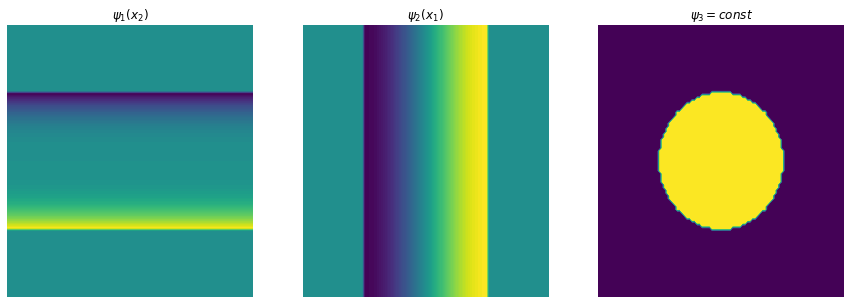

In [34]:
plt.figure(figsize=(3*5,5))

plt.subplot(1,3,1)
plt.contourf(np.array(x_1),np.array(x_2), np.array(psi_1), n)
plt.title('$\psi_1(x_2)$')
plt.axis(False)

plt.subplot(1,3,2)
plt.contourf(np.array(x_1),np.array(x_2), np.array(psi_2), n)
plt.title('$\psi_2(x_1)$')
plt.axis(False)

plt.subplot(1,3,3)
plt.contourf(np.array(x_1),np.array(x_2), np.array(psi_3), n)
plt.title('$\psi_3 = const$')
plt.axis(False)

plt.show()

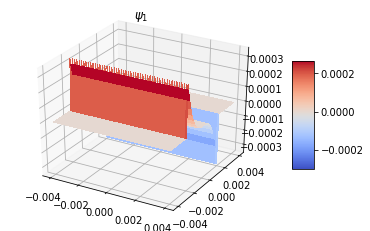

In [35]:
fig1, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf1 = ax.plot_surface(np.array(x_1),np.array(x_2), np.array(psi_1), cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig1.colorbar(surf1, shrink=0.5, aspect=5)
plt.title('$\psi_1$')
plt.show()

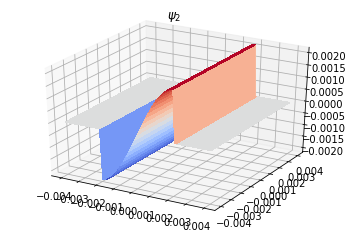

In [36]:
fig2, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf2 = ax.plot_surface(np.array(x_1),np.array(x_2), np.array(psi_2), cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig1.colorbar(surf2, shrink=0.5, aspect=5)
plt.title('$\psi_2$')
plt.show()

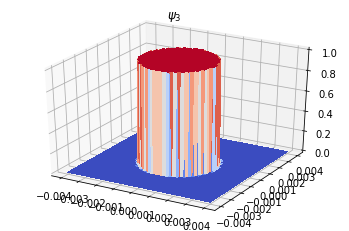

In [37]:
fig3, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf3 = ax.plot_surface(np.array(x_1),np.array(x_2), np.array(psi_3), cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig1.colorbar(surf3, shrink=0.5, aspect=5)
plt.title('$\psi_3$')
plt.show()